In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import fsolve

In [2]:
# Input datas for IPR
Qo_IPR = 250
Pwf_IPR = 2500
Pr = 3000
Pb = 2130
delta_P_skin = 200 # from DST

# Calculating Flow Efficency
F = (Pr - Pwf_IPR - delta_P_skin)/(Pr - Pwf_IPR)

In [3]:
def Vogel_IPR(Qo, Pwf, Pr, Pb):

    #Saturated Reservoir
    if Pr<=Pb:
        Qo_max = Qo/(1 - 0.2*(Pwf/Pr) - 0.8*(Pwf/Pr)**2)
        Pwf_array = np.linspace(Pr, 0, 30)
        Qo_array = Qo_max*(1 - 0.2*(Pwf_array/Pr) - 0.8*(Pwf_array/Pr)**2)

    #Understaturated Reservoir
    else:
        if Pwf>Pb:
            J = Qo/(Pr - Pwf)
            Qob = J*(Pr - Pb)
            Qo_1 = J*(Pr - np.linspace(Pr, Pb, 10))
            Qo_2 = Qob + (J*Pb/1.8)*(1 - 0.2*(np.linspace(Pb, 0, 10)/Pb) - 0.8*(np.linspace(Pb, 0, 10)/Pb)**2)
            Pwf_array = np.concatenate((np.linspace(Pr, Pb, 10), np.linspace(Pb, 0, 10)[1:]))
            Qo_array = np.concatenate((Qo_1,Qo_2[1:]))
        else:
            J = Qo/((Pr - Pb) + (Pb/1.8)*(1 - 0.2*(Pwf/Pb) - 0.8*(Pwf/Pb)**2))
            Qob = J*(Pr - Pb)
            Qo_1 = J*(Pr - np.linspace(Pr, Pb, 10))
            Qo_2 = Qob + (J*Pb/1.8)*(1 - 0.2*(np.linspace(Pb, 0, 10)/Pb) - 0.8*(np.linspace(Pb, 0, 10)/Pb)**2)
            Pwf_array = np.concatenate((np.linspace(Pr, Pb, 10), np.linspace(Pb, 0, 10)[1:]))
            Qo_array = np.concatenate((Qo_1,Qo_2[1:]))

    return Pwf_array, Qo_array


In [4]:
Pwf_array_IPR, Qo_array_IPR = Vogel_IPR(Qo_IPR, Pwf_IPR, Pr, Pb)

In [5]:
# Interpolation
from scipy.interpolate import splrep, splev
Pwf_predictator_IPR = splrep(Qo_array_IPR, Pwf_array_IPR, k=3, s=9)
Pwf_predicted_IPR = splev(Qo_array_IPR, Pwf_predictator_IPR)

In [6]:
# Input Datas for VLP
Pwh_VLP = 100
T = 150 + 460
d = 2.441
API = 35
GLR = 273
Bw = 1.01
fo = 1.0
fw = 0.0
Yg = 0.75 # gas gravity
Yo = 0.55 # Oil gravity
Yw = 1.05 # water gravity
depth = 5000

In [7]:
def Poettmann_and_Carpenter_Method(Pwh, T, d, API, GLR, Bw, fo, fw, Yg, Yo, Yw, Ql, depth):
    i = 0
    Pwf = np.zeros_like(Ql)

    for i in range(len(Ql)):
         # Calculated Datas
         Tpc = 168 + 325 * Yg - 12.5 * Yg**2
         Tpr = T / Tpc
         Ppc = 677 + 15.0 * Yg - 37.5 * Yg**2
         M = 350.376 * (fo * Yo + fw * Yw) + 0.0763 * Yg * GLR
         Dvp = 176.844 * (10**-6) * (M * Ql[i] / d)
         Ef = 46.0115 * Dvp**-3.092368 + 60.37 * (10**-6) * (Dvp**-1) + 0.00524355
         K_bar = (3.3567 * (10**-6) * (Ql[i]**2) * (M**2) * Ef) / (d**5)


         # Initialize an empty list to store data
         data_list = []

         # Moving till depth
         delta_p = 0
         H = 0
         DTT = 0
         P = Pwh
         while DTT < depth - 1:
              if DTT < depth - 50:
                  P += delta_p
                  P_avg = P - delta_p / 2
                  Rs = Yg * ((P_avg / 18.2 + 1.4) * 10**(0.0125 * API - 0.00091 * (T - 460)))**1.2048
                  Bo = 0.9759 + 0.000120 * (Rs * ((Yg / Yo)**0.5) + 1.25 * (T - 460))**1.2
                  Ppr = P_avg / Ppc
                  Z = 1.008505 + 0.04623 * (Ppr / Tpr) + (0.862707 * Ppr**1.368627) / (10**(0.636778 * Tpr)) - (2.324825 * Ppr) / (10**(0.649787 * Tpr))
                  Bg = 0.02827 * Z * T / P_avg
                  Row_bar = M / (5.614 * (fo * Bo + fw * Bw) + Bg * (GLR - fo * Rs))
                  delta_h = 144.9 * delta_p / (Row_bar + K_bar / Row_bar)
                  delta_p = 5
                  DTT += delta_h
                  # Append a dictionary to the list
                  data_list.append({
                      'Assumed Pressure (psi)': P,
                      'Avg. Pressure (psi)': P_avg,
                      'Rs': Rs,
                      'Bo': Bo,
                      'Ppr': Ppr,
                      'Z': Z,
                      'Bg': Bg,
                      'Avg. Density': Row_bar,
                      'Increment in Depth': delta_h,
                      'Depth to Top': DTT
                                    })

              else:
                  delta_p = 1
                  P += delta_p
                  P_avg = P - delta_p / 2
                  Rs = Yg * ((P_avg / 18.2 + 1.4) * 10**(0.0125 * API - 0.00091 * (T - 460)))**1.2048
                  Bo = 0.9759 + 0.000120 * (Rs * ((Yg / Yo)**0.5) + 1.25 * (T - 460))**1.2
                  Ppr = P_avg / Ppc
                  Z = 1.008505 + 0.04623 * (Ppr / Tpr) + (0.862707 * Ppr**1.368627) / (10**(0.636778 * Tpr)) - (2.324825 * Ppr) / (10**(0.649787 * Tpr))
                  Bg = 0.02827 * Z * T / P_avg
                  Row_bar = M / (5.614 * (fo * Bo + fw * Bw) + Bg * (GLR - fo * Rs))
                  delta_h = 144.9 * delta_p / (Row_bar + K_bar / Row_bar)
                  DTT += delta_h
                  # Append a dictionary to the list
                  data_list.append({
                        'Assumed Pressure (psi)': P,
                        'Avg. Pressure (psi)': P_avg,
                        'Rs': Rs,
                        'Bo': Bo,
                        'Ppr': Ppr,
                        'Z': Z,
                        'Bg': Bg,
                        'Avg. Density': Row_bar,
                        'Increment in Depth': delta_h,
                        'Depth to Top': DTT
                                     })

         # Saving datas into Excel
         df = pd.DataFrame(data_list)
         Pwf[i] = df['Assumed Pressure (psi)'].iloc[-1]
    return Pwf


In [8]:
Qo_array_VLP = Qo_array_IPR[1:]
Pwf_array_VLP= Poettmann_and_Carpenter_Method(Pwh_VLP, T, d, API, GLR, Bw, fo, fw, Yg, Yo, Yw, Qo_array_VLP, depth)

In [9]:
# Interpolation
from scipy.interpolate import splrep, splev
Pwf_predictator_VLP = splrep(Qo_array_VLP, Pwf_array_VLP, k=3, s=9)
Pwf_predicted_VLP = splev(Qo_array_VLP, Pwf_predictator_VLP )

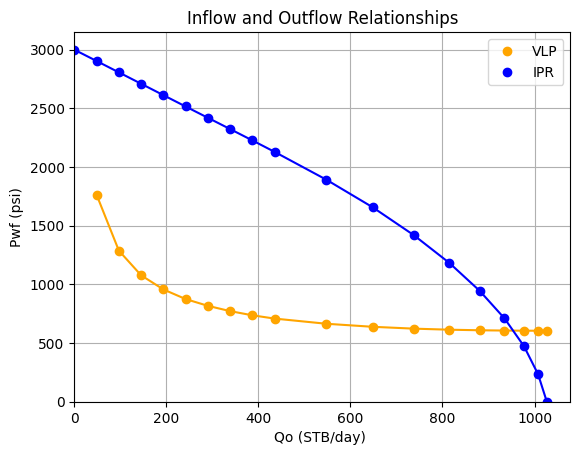

In [10]:
# Create the plot
plt.plot( Qo_array_VLP, Pwf_predicted_VLP, 'o', label='VLP', color='orange')
plt.plot(Qo_array_VLP, Pwf_predicted_VLP, '-', color='orange')
plt.plot( Qo_array_IPR, Pwf_array_IPR, 'o', label='IPR', color='blue')
plt.plot(Qo_array_IPR, Pwf_predicted_IPR, '-', color='blue')

# Set the y-axis limits to start at the bottom of the well till top (inverted)
plt.ylim(0, )
plt.xlim(0, )

# Customize labels and title
plt.xlabel('Qo (STB/day) ')
plt.ylabel('Pwf (psi)')
plt.title('Inflow and Outflow Relationships')

# Add a horizontal line at y=0 for better visualization of mirrored effect (optional)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

# Adjust legend placement (optional)
plt.legend(loc='upper right')

# Display the plot
plt.grid(True)
plt.show()

In [11]:
def find_intersection(Qo, Pwf_predictator_VLP_in, Pwf_predictator_IPR_in):
    Pwf_VLP = splev(Qo, Pwf_predictator_VLP_in)
    Pwf_IPR = splev(Qo, Pwf_predictator_IPR_in)
    return Pwf_VLP - Pwf_IPR

# Example usage with different pairs of curves
def calculate_intersection(Pwf_predictator_VLP_in, Pwf_predictator_IPR_in, initial_guess=500.0):
    Qo_intersection = fsolve(find_intersection, initial_guess, args=(Pwf_predictator_VLP_in, Pwf_predictator_IPR_in))
    Pwf_intersection = splev(Qo_intersection, Pwf_predictator_VLP_in)
    return Qo_intersection[0], Pwf_intersection[0]

In [28]:
print(f"Operating Condition: ( Qo (STB/day), Pwf (psi) ) = ({calculate_intersection(Pwf_predictator_VLP, Pwf_predictator_IPR, initial_guess=500.0)[0]:.2f}, {calculate_intersection(Pwf_predictator_VLP, Pwf_predictator_IPR, initial_guess=500.0)[1]:.2f})")

Operating Condition: ( Qo (STB/day), Pwf (psi) ) = (954.72, 605.95)


In [25]:
# Effect of skin (increasing or decreasing drawdown)
def skin(delta_P_skin_red):
    F_new = (Pr - Pwf_IPR - (delta_P_skin-delta_P_skin_red) )/(Pr - Pwf_IPR)
    Pwf_array_IPR_new, Qo_array_new = Vogel_IPR(Qo_IPR, Pwf_IPR + delta_P_skin_red, Pr, Pb)
    Pwf_predictator_IPR_new = splrep(Qo_array_new, Pwf_array_IPR_new, k=3, s=9)
    Pwf_predicted_IPR_new = splev(Qo_array_new, Pwf_predictator_IPR_new)

    Qo_array_VLP1 = Qo_array_new[1:] if Qo_array_new[len(Qo_array_new) - 1] >= Qo_array_IPR[len(Qo_array_IPR)-1] else Qo_array_IPR[1:]
    Pwf_array_VLP1 = Poettmann_and_Carpenter_Method(Pwh_VLP, T, d, API, GLR, Bw, fo, fw, Yg, Yo, Yw, Qo_array_VLP, depth)
    Pwf_predictator_VLP1 = splrep(Qo_array_VLP, Pwf_array_VLP, k=3, s=9)
    Pwf_predicted_VLP1 = splev(Qo_array_VLP, Pwf_predictator_VLP )

    print(f"New Operating Condition: ( Qo (STB/day), Pwf (psi) ) = ({calculate_intersection(Pwf_predictator_VLP1, Pwf_predictator_IPR_new, initial_guess=500.0)[0]:.2f}, {calculate_intersection(Pwf_predictator_VLP1, Pwf_predictator_IPR_new, initial_guess=500.0)[1]:.2f})")

    # Create the plot
    plt.plot( Qo_array_VLP1, Pwf_predicted_VLP1, 'o', label='VLP', color='orange')
    plt.plot(Qo_array_VLP1, Pwf_predicted_VLP1, '-', color='orange')
    plt.plot( Qo_array_IPR, Pwf_array_IPR, 'o', label=f'IPR (Actual i.e. F={F})', color='blue')
    plt.plot(Qo_array_IPR, Pwf_predicted_IPR, '-', color='blue')
    #plt.plot( Qo_array_new , Pwf_array_IPR_new, 'o', label=f'IPR (New i.e. F={F_new})', color='blue')
    plt.plot(Qo_array_new ,  Pwf_predicted_IPR_new, '--', label=f'IPR (New i.e. F={F_new})', color='black')

    # Set the y-axis limits to start at the bottom of the well till top (inverted)
    plt.ylim(0, )
    plt.xlim(0, )

    # Customize labels and title
    plt.xlabel('Qo (STB/day) ')
    plt.ylabel('Pwf (psi)')
    plt.title('Inflow and Outflow Relationships')

    # Add a horizontal line at y=0 for better visualization of mirrored effect (optional)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

    # Adjust legend placement (optional)
    plt.legend(loc='upper right')

    # Display the plot
    plt.grid(True)
    plt.show()

New Operating Condition: ( Qo (STB/day), Pwf (psi) ) = (1594.71, 594.20)


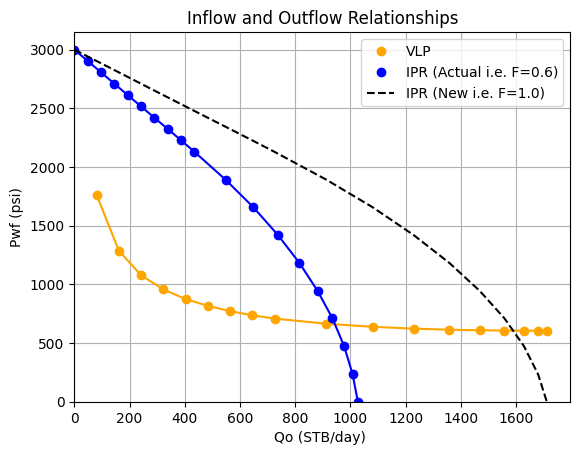

In [26]:
skin(delta_P_skin)

In [17]:
# Effect of tubing
def tubing_effect(d_new):
    Pwf_array_VLP1 = Poettmann_and_Carpenter_Method(Pwh_VLP, T, d_new, API, GLR, Bw, fo, fw, Yg, Yo, Yw, Qo_array_VLP, depth)
    Pwf_predictator_VLP1 = splrep(Qo_array_VLP, Pwf_array_VLP1, k=3, s=9)
    Pwf_predicted_VLP1 = splev(Qo_array_VLP, Pwf_predictator_VLP )

    Qo , Pwf  = calculate_intersection(Pwf_predictator_VLP1, Pwf_predictator_IPR, initial_guess=500.0)

    # Create the plot
    plt.plot( Qo_array_VLP, Pwf_predicted_VLP, 'o', label=f'VLP with d={d} inch', color='orange')
    plt.plot(Qo_array_VLP, Pwf_predicted_VLP, '-', color='orange')
    plt.plot(Qo_array_VLP, Pwf_array_VLP1, '--',label=f'VLP with d={d_new} inch', color='black')
    plt.plot( Qo_array_IPR, Pwf_array_IPR, 'o', label=f'IPR', color='blue')
    plt.plot(Qo_array_IPR, Pwf_predicted_IPR, '-', color='blue')

    # Set the y-axis limits to start at the bottom of the well till top (inverted)
    plt.ylim(0, )
    plt.xlim(0, )

    # Customize labels and title
    plt.xlabel('Qo (STB/day) ')
    plt.ylabel('Pwf (psi)')
    plt.title('Inflow and Outflow Relationships')

    # Add a horizontal line at y=0 for better visualization of mirrored effect (optional)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

    # Adjust legend placement (optional)
    plt.legend(loc='upper right')

    # Display the plot
    plt.grid(True)
    plt.show()
    return Qo , Pwf

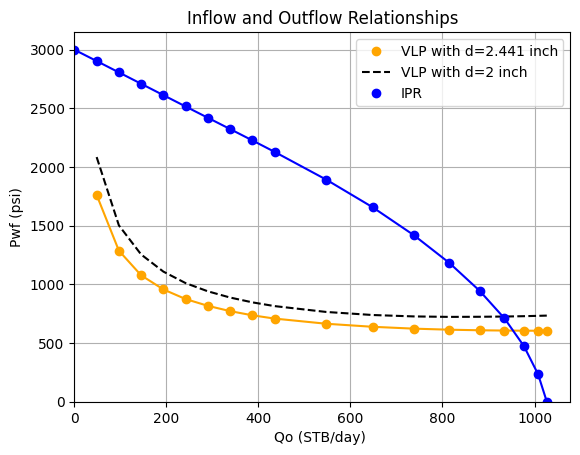

New Operating Condition: ( Qo (STB/day), Pwf (psi) ) = ( 931.58 , 725.77 )


In [29]:
p = tubing_effect(2)
print(f"New Operating Condition: ( Qo (STB/day), Pwf (psi) ) = ( {p[0]:.2f} , {p[1]:.2f} )")

In [30]:
# Effect of Pwh
def Pwh_effect(Pwh_new):
    Pwf_array_VLP1 = Poettmann_and_Carpenter_Method(Pwh_new, T, d, API, GLR, Bw, fo, fw, Yg, Yo, Yw, Qo_array_VLP, depth)
    Pwf_predictator_VLP1 = splrep(Qo_array_VLP, Pwf_array_VLP1, k=3, s=9)
    Pwf_predicted_VLP1 = splev(Qo_array_VLP, Pwf_predictator_VLP )

    print(f"New Operating Condition: ( Qo (STB/day), Pwf (psi) ) = ({calculate_intersection(Pwf_predictator_VLP1, Pwf_predictator_IPR, initial_guess=500.0)[0]:.2f}, {calculate_intersection(Pwf_predictator_VLP1, Pwf_predictator_IPR, initial_guess=500.0)[1]:.2f})")

    # Create the plot
    plt.plot( Qo_array_VLP, Pwf_predicted_VLP, 'o', label=f'VLP with Pwh={Pwh_VLP} psi', color='orange')
    plt.plot(Qo_array_VLP, Pwf_predicted_VLP, '-', color='orange')
    plt.plot(Qo_array_VLP, Pwf_array_VLP1, '--',label=f'VLP with Pwh={Pwh_new} psi', color='black')
    plt.plot( Qo_array_IPR, Pwf_array_IPR, 'o', label=f'IPR', color='blue')
    plt.plot(Qo_array_IPR, Pwf_predicted_IPR, '-', color='blue')

    # Set the y-axis limits to start at the bottom of the well till top (inverted)
    plt.ylim(0, )
    plt.xlim(0, )

    # Customize labels and title
    plt.xlabel('Qo (STB/day) ')
    plt.ylabel('Pwf (psi)')
    plt.title('Inflow and Outflow Relationships')

    # Add a horizontal line at y=0 for better visualization of mirrored effect (optional)
    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

    # Adjust legend placement (optional)
    plt.legend(loc='upper right')

    # Display the plot
    plt.grid(True)
    plt.show()

New Operating Condition: ( Qo (STB/day), Pwf (psi) ) = (970.24, 515.87)


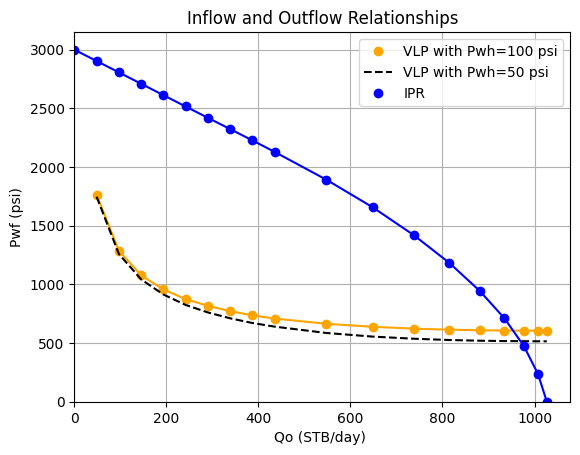

In [31]:
Pwh_effect(50)

In [32]:
def optimum_tubing(d_range):
    i = 1
    new_1 = tubing_effect(d_range[0])
    print(f"Operating Condition for {d_range[0]} inch tubing: ( Qo (STB/day), Pwf (psi) ) = ( {new_1[0]:.2f} , {new_1[1]:.2f} )")
    Q_1 = float(new_1[0])  # Convert to Python float
    new_2 = tubing_effect(d_range[1])
    print(f"Operating Condition for {d_range[1]} inch tubing: ( Qo (STB/day), Pwf (psi) ) = ( {new_2[0]:.2f} , {new_2[1]:.2f} )")
    Q_2 = float(new_2[0])  # Convert to Python float

    while (Q_2 - Q_1) > 100:
        Q_1 = Q_2
        new = tubing_effect(d_range[i])
        print(f"Operating Condition for {d_range[i]} inch tubing: ( Qo (STB/day), Pwf (psi) ) = ( {new[0]:.2f} , {new[1]:.2f} )")
        Q_2 = float(new[0])  # Convert to Python float
        i += 1

    return d_range[i - 1]


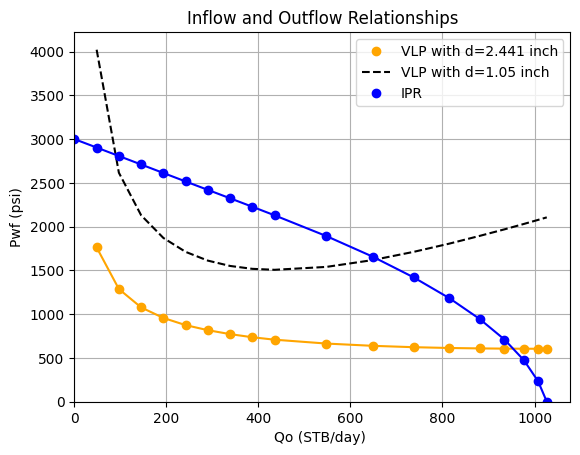

Operating Condition for 1.05 inch tubing: ( Qo (STB/day), Pwf (psi) ) = ( 659.68 , 1628.60 )


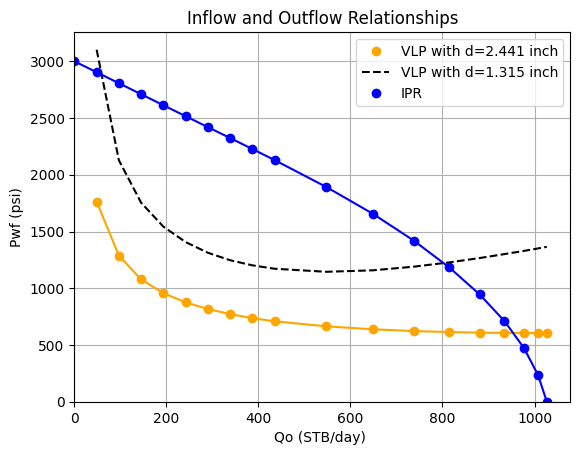

Operating Condition for 1.315 inch tubing: ( Qo (STB/day), Pwf (psi) ) = ( 803.24 , 1221.14 )


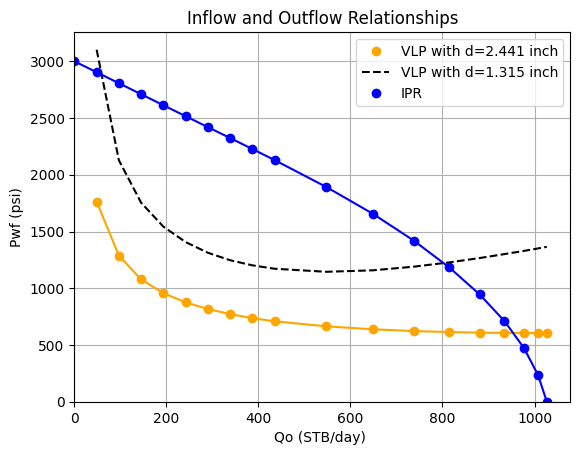

Operating Condition for 1.315 inch tubing: ( Qo (STB/day), Pwf (psi) ) = ( 803.24 , 1221.14 )
Optimum Tubing Size is 1.315 inch


In [33]:
d_range = [1.050,1.315,1.660,1.900,2.063,2.375,2.441,2.875,3.5,4,4.5]
print(f'Optimum Tubing Size is {optimum_tubing(d_range)} inch')